# GeoClaw topotools examples

This notebook contains some examples of working with the *clawpack.geoclaw.topotools* module.  These tools facilitate creating and manipulating the *topo* files that are required as GeoClaw input to specify topography and bathymetry (underwater topography).

See <http://clawpack.github.io/doc/topotools.html> for general documentation of these tools and their use in the context of GeoClaw, and <http://www.clawpack.org> for more information on the Clawpack suite of software.

## Contents

 - <a href="#fetch">Fetching a topo file from the web</a>
 - <a href="#read">Reading a topo file</a>
 - <a href="#plot">Plotting topography data</a>
 - <a href="#crop">Cropping topography</a>
 - <a href="#unstructured">Unstructured topography</a>

### Setup notebook and environment:

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from clawpack.geoclaw import topotools
import os
CLAW = os.environ['CLAW']
datadir = os.path.join(CLAW,'geoclaw','scratch') # directory for some sample data files

<div id="fetch"></div>
## Fetching a topo file from the web

Many GeoClaw examples are set up to use topography files that have already been created and archived on the web, e.g. the example found in `$CLAW/geoclaw/examples/tsunami/chile2010` uses a topo file that can be obtained by these commands (which are also found in the Python script `maketopo.py` found in that directory):

In [3]:
from clawpack.clawutil.data import get_remote_file
filename = 'etopo10min120W60W60S0S.asc'
url = 'http://www.geoclaw.org/topo/etopo/' + filename
get_remote_file(url=url, output_dir=datadir, force=True, verbose=True)

File already exists, not downloading


'/Users/rjl/git/clawpack/geoclaw/scratch/etopo10min120W60W60S0S.asc'

If all you want to do is use this topo file in a GeoClaw run, you do not need to use any further Python tools.

<div id="read"></div>

## Reading a topo file

In order to plot or manipulate the topo data, we first read the file we just downloaded into a `topotools.Topography` object.  To do so, we must know how the data is formatted.  This file is in the format `topo_type==2` as described at <http://clawpack.github.io/doc/topo.html>:

In [4]:
topo_path = os.path.join(datadir, filename)
topo = topotools.Topography()
topo.read(topo_path, topo_type=2)

We can now do various things with the data.  First let's print out some basic attributes:

In [5]:
print "The extent of the data in longitude and latitude: "
print topo.extent

The extent of the data in longitude and latitude: 
[-120.0, -59.999999999879996, -60.0, 1.2000356264252332e-10]


In [6]:
print "The shapes of 1-dimensional arrays of longitude x and latitude y values:", topo.x.shape, topo.y.shape
print "The shapes of 2-dimensional arrays X,Y and the topography data Z:", topo.Z.shape

The shapes of 1-dimensional arrays of longitude x and latitude y values: (361,) (361,)
The shapes of 2-dimensional arrays X,Y and the topography data Z: (361, 361)


From the filename you might guess this is 10-arcminute data, we can check that it is:

In [7]:
print "topo.delta = ",topo.delta
print "10 arcminutes is 1/6 degree = %8.6f degree" % (1./6.)

topo.delta =  (0.166666666667, 0.166666666667)
10 arcminutes is 1/6 degree = 0.166667 degree


<div id=plot></div>
## Plotting topography data

A simple plot with various defaults used can be obtained simply by:

/Users/rjl/anaconda/envs/jupyter/lib/python2.7/site-packages/matplotlib/axes/_base.py:1057: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':
/Users/rjl/anaconda/envs/jupyter/lib/python2.7/site-packages/matplotlib/axes/_base.py:1062: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):


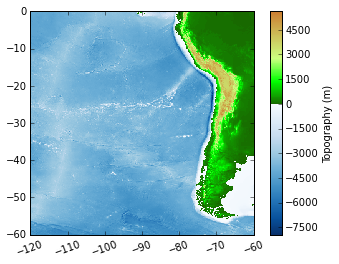

In [8]:
topo.plot()

Various arguments can be supplied for more control, see the documentation.

Of course you can plot the data any way you want using the X, Y, and Z attributes, e.g.

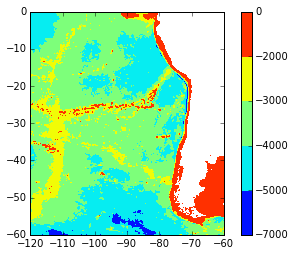

In [9]:
contourf(topo.X, topo.Y, topo.Z, [-7000, -5000, -4000, -3000, -2000, 0])
colorbar()
# rescale aspect ratio based on mean latitude so distances more correct:
gca().set_aspect(1.0 / cos(pi / 180.0 * topo.y.mean()))  

<div id=crop></div>
## Cropping topography

Sometimes it is useful to crop a large topo file to create a smaller one that contains a sub-region, e.g.

In [10]:
filter_region = (-90, -60, -60, -40)
topo2 = topo.crop(filter_region)
topo2.Z.shape

(120, 180)

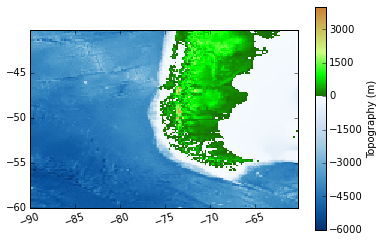

In [11]:
topo2.plot()

The cropped topography can be written out to a new file, which will be smaller than the original:

In [12]:
topo2_path = os.path.join(datadir,'tip_of_south_america.tt3')
topo2.write(topo2_path, topo_type=3)

In [13]:
print "Size of the new file: %s bytes" % os.stat(topo2_path).st_size
print "Size of the original file: %s bytes" % os.stat(topo_path).st_size

Size of the new file: 540384 bytes
Size of the original file: 985529 bytes


To obtain topography for other regions, see the links at <http://clawpack.github.io/doc/tsunamidata.html>

<div id=unstructured></div>
## Unstructured Topography

The `topotools` and `Topography` class also have facilities for handling unstructured topography data.  To start we will randomly sample the data we were working with above to get an unstructured data file.  Here we generate random tuples of longitude-latitude and interpolate the original data so we can get a field at the random points.

In [14]:
import scipy.interpolate as interpolate

N = 10000

x = numpy.random.rand(N) * (topo.x[-1] - topo.x[0]) + topo.x[0]
y = numpy.random.rand(N) * (topo.y[-1] - topo.y[0]) + topo.y[0]

# Here we need to transpose the Z array so that the coordinate evaluation is correct
bathy = interpolate.RectBivariateSpline(topo.x, topo.y, topo.Z.transpose())

# strange hack to evaluate the function `bathy` produced by RectBivariateSpline since bathy(x, y) does not work
z = numpy.empty(x.shape)
for i in xrange(x.shape[0]):
    z[i] = bathy(x[i], y[i])

Now lets construct the unstructured topography object based on the random locations we just generated.

In [15]:
unstructured_topo = topotools.Topography(unstructured=True)
unstructured_topo.x = x
unstructured_topo.y = y
unstructured_topo.z = z

We can plot the data as is to see what we randomly created so far

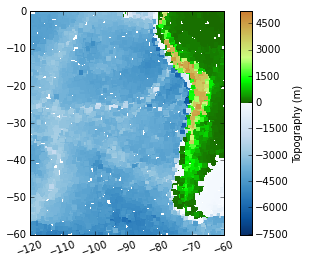

In [16]:
unstructured_topo.plot()

One of the primary things we want to be able to do with unstructured topography data is to turn it into structured data which GeoClaw can use.  In order to do this, there is a method in the `Topography` class called `interp_unstructured` which has a number of options.  Here we will just go with the defaults (please see the documentation for the full assortment of options).   In this case we will provide two things to the routine.  The first is topography to use to fill in possible gaps in the unstructured topography.  This "fill topography" can be structured or unstructured.  The second argument we provide is a limit on the calculated grid spacing.  The routine attempts to calculate the minimum distance between two points and uses this as the basis of the structured grid.  Placing a limit on this insures that the resulting grid is not too fine.  Addtional options for filtering the data in the routine, smoothing and interpolation strategies are also available.

In [17]:
unstructured_topo.interp_unstructured(topo, delta_limit=10000)

Now that the topography has been interpolated onto a new grid, we can check to see if the `unstructured` attribute is in fact now set to `False`.

In [18]:
unstructured_topo.unstructured

False

Usually at this point you will want to save out a copy of the interpolated topography for use with GeoClaw, the usual functions from before work of course.  More interesting is to plot the new topography which we can again do by using the `plot` function:

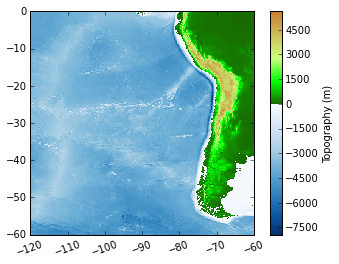

In [19]:
unstructured_topo.plot()